## heterogeneity metric

### libraries

In [1]:
import os
import tensorflow as tf 
import numpy as np 
from sklearn.metrics import confusion_matrix
import pickle
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np 
import umap
import seaborn as sns 
import cv2 
import math 
import pandas as pd

### instance paths

In [2]:
path_to_features = '/Users/saskia/unibe19/master_thesis/TKI_project/feature_maps/' 
path_to_Xs_and_Ys = '/Users/saskia/unibe19/master_thesis/TKI_project/Xs_and_Ys/' 
path_to_info = "/Users/saskia/unibe19/master_thesis/TKI_project/data/dataset_PC_HN/info.pckl"

### import feature vectors, images and labels 

In [3]:
feature_vectors, labels, folder_labels = pickle.load(open(os.path.join(path_to_features, 
                                                                       'featuresVectors_with_labels.pckl'), 'rb')) 

Xs = pickle.load(open(os.path.join(path_to_Xs_and_Ys, 'images.pckl'), 'rb')) 
Ys = pickle.load(open(os.path.join(path_to_Xs_and_Ys, 'labels.pckl'), 'rb'))

info = pickle.load(open(path_to_info, "rb"))

In [4]:
labels = [info[Ys[i]]['stim'] for i in Ys]
#labels

### grouping of feature vectors into the individual original images 

In [5]:
constante = 32 # features are a downscaled representation of the original images 
features_per_image = [] 
h = math.ceil(Xs.shape[1]/constante)
w = math.ceil(Xs.shape[2]/constante)
for i in range(len(Xs)):
    lower_index = i * h * w
    upper_index = (i+1) * h * w
    features_per_image.append(feature_vectors[lower_index:upper_index, :])

### heterogeneity metric for each images 

This was done by dividing the feature vectors by the euclidean norm to get vectors of length one. 
Then the mean of all vectors of length one was computed. 
Finally, the euclidean norm of the mean was compute again to get us a scalar per images. 

In [6]:
hetero_m = []
for i in range(len(features_per_image)): 
    norms = np.linalg.norm(features_per_image[i], axis=1) 
    new_vector = []
    for j in range(norms.shape[0]): 
        new_vector.append(features_per_image[i][j]/norms[j]) 
    hetero_m.append(np.linalg.norm(np.mean(new_vector, axis=0)))

#### create dataframe with the heterogeneity metrics:

In [7]:
hetero_m = np.asarray(hetero_m)
df = pd.DataFrame(data=hetero_m, columns=['hm'])

add stimulation conditions to it:

In [9]:
df['stim_cond'] = labels 
#df

##### for which indices do we find the larger/smaller metrics? 
in order to look at the original images and overlays

In [11]:
idx = np.where(hetero_m < 0.45)[0]
idx

array([ 95, 137, 150])

In [12]:
idx = np.where(hetero_m > 0.90)[0]
idx

array([13, 14, 94])

### distribution of heterogeneity metrics per stimulation conditions

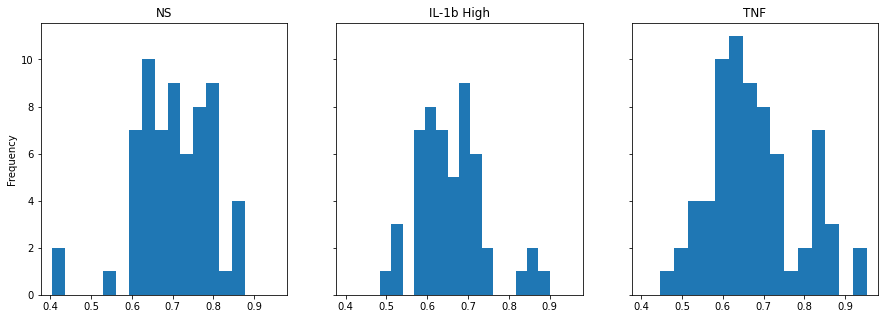

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

gb = df.groupby('stim_cond')
desired_order = ('NS', 'IL-1b High', 'TNF')
for (universe, group), ax in zip(((u, gb.get_group(u)) for u in desired_order), axes.flatten()): 
    group['hm'].plot(kind='hist', ax=ax, title=universe, bins=15) 
    the_mean = df[df['stim_cond']==universe].mean(numeric_only=True)

plt.savefig('/Users/saskia/unibe19/master_thesis/TKI_project/report/figures/hetero_distr.png')

### heterogeneity metric means grouped by stimulation conditions

In [14]:
df[df['stim_cond']=='NS'].mean(numeric_only=True)

hm    0.706394
dtype: float32

In [15]:
df[df['stim_cond']=='IL-1b High'].mean(numeric_only=True)

hm    0.658579
dtype: float32

In [16]:
df[df['stim_cond']=='TNF'].mean(numeric_only=True)

hm    0.679782
dtype: float32

### investigating the effect heterogenity distribution grouped by folders

Images come from folders. Each folder have one of the specific stimulation condition. 
There are not only 3 (or 5) of them because images also come from different sets of experiments, 
resulting in the final amount of folders. 
As some experiments have been performed by different experimentators, 
here I am aiming at finding if heterogeneity could also be influenced by the *set* factor. 

4 sets of experiments:

- 0-5
- 6-8
- 9-23
- 24-28


This investigation was motivated also by the fact that 
from the 3-component-UMAP-transformed-to-RGB images, I notice that each stimulation conditions 
could be visually and easily segregated in two further clusters. 

Here are the sub-group I created:

| condition     |                            |
| :------------ | :------------------------- |
| NS            |                   3, 4, 26 |
| **NS**        |     **12, 16, 19, 22, 25** |
| IL-1b         |                 0, 2, 5, 9 |
| **IL-1b**     |      **7, 10, 14, 17, 20** |
| TNF           |                          1 |
| **TNF**       | **11, 13, 15, 18, 21, 23** |

$\rightarrow$ 6-8 and 9-23 was performed by the same person (in **bold**)

so the model extracted features that result from different manner to handle cells and conduct the experiment, 
highlignthing the fact that a different experimator have an impact on the resulting cell monolayer pictures 

In [17]:
df['folder'] = Ys

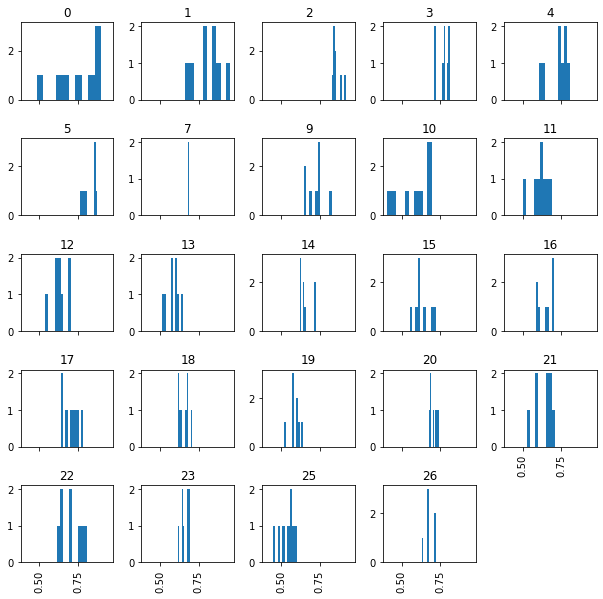

In [18]:
p = df.hist(column='hm', by='folder', sharex=True, figsize=(10,10))